# Train an mmdetection object detection model

In [2]:
from pathlib import Path
import pyprojroot
dir_proj = pyprojroot.here()
print("Project directory:", dir_proj)

import torch
import mmdet
import mmcv

# At least 1 gpu is needed for this to run reasonably quickly.
print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print("GPU device count:", torch.cuda.device_count())
print("CUDA version:", torch.version.cuda)
print("PyTorch CUDA archs:", torch.cuda.get_arch_list())
print("mmcv version:", mmcv.__version__)
print("mmdet version:", mmdet.__version__) # tracking dev-3.x for mmyolo conda; 2.28.2 otherwise
#import mmyolo
#print("mmyolo version:", mmyolo.__version__)
#import mmengine
#print("mmengine version:", mmengine.__version__) # Should be 0.7

Project directory: /home/ck37/projects/ecig-vaping
PyTorch version: 1.13.1
GPU available: True
GPU device count: 4
CUDA version: 11.7
PyTorch CUDA archs: ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']
mmcv version: 1.6.0
mmdet version: 2.28.2


## Train

In [3]:
from pathlib import Path
import time
dir_models = dir_proj / "models"

#########
## mmdet2

#model_name = "faster_rcnn_r50_caffe_fpn_1x_coco"
#model_name = "faster_rcnn_x101_64x4d_fpn_1x_coco"
#model_name = "faster_rcnn_x101_64x4d_fpn_mstrain_3x_coco" # gives nan loss by epoch 3
#model_name = "retinanet_pvtv2-b5_fpn_1x_coco"

#model_name = "vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco" # main model (2022-10-X)
model_name = "dyhead" # 2023-03-04

####
# mmdet3 / mmyolo

#model_name = "vfnetx_r2_101_vape" # New test 2023-03-25 - sadly not supported by mmdetection
#model_name = "ppyoloe_plusx" # 2023-03-04
#model_name = "vfnet-mmdet3"

path_model = dir_models / str(model_name + ".py")
print("Model:", path_model)
if not path_model.exists():
    print("Error: model config not found.")

Model: /home/ck37/projects/ecig-vaping/models/dyhead.py


In [12]:
# **** Only for mmyolo conda env and ppyoloe model. ****

# Check dataset
# training set
!python ../external/mmyolo/tools/analysis_tools/dataset_analysis.py {path_model}

# Validation set
!python ../external/mmyolo/tools/analysis_tools/dataset_analysis.py {path_model} \
    --val-dataset


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


Print current running information:
+--------------------------------------------------------------------+
|                        Dataset information                         |
+---------------+-------------+--------------+-----------------------+
|  Dataset type |  Class name |   Function   |       Area rule       |
+---------------+-------------+--------------+-----------------------+
| train_dataset | All classes | All function | [0, 32, 96, 100000.0] |
+---------------+-------------+--------------+-----------------------+

Read the information of each picture in the dataset:
[>>>>>>>>>>>>>>>>>>>>>>>>>] 1977/1977, 43966.1 task/s, elapsed: 0s, ETA:     0s

The information obtained is as follows:
+-------------------------------------+
|     Information of dataset class    |
+--------------------------+----------+
| Class name               | Bbox num |
+--------------------------+----------+
| box   

In [8]:
timestr = time.strftime("%Y%m%d-%H%M%S")
print("Time string:", timestr)

# 2 = number of GPUs to use.
# mmdet2 training
!../external/mmdetection/tools/dist_train.sh {path_model} 2 \
   --work-dir work_dirs/{model_name}-{timestr}

# mmdet3 training
#!CUDA_VISIBLE_DEVICES=2 ../external/mmdet-for-yolo/tools/dist_train.sh {path_model} 2 \
#   --work-dir work_dirs/{model_name}-{timestr}

#!python ../external/mmdet-for-yolo/tools/train.py {path_model} \
#   --work-dir work_dirs/{model_name}-{timestr}

### mmyolo training
#!CUDA_VISIBLE_DEVICES=1 python ../external/mmyolo/tools/train.py {path_model} \
#    --work-dir work_dirs/{model_name}-{timestr}

Time string: 20230325-193432
/home/ck37/.conda/envs/mmdet/lib/python3.9/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
/home/ck37/projects/ecig-vaping/external/mmdetection/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid you

## Evaluate

In [10]:
# Copy-paste metrics: mAP mAP_50 mAP_s mAP_m mAP_l

# Faster RCNN R50 FPN 1x Coco
# Updated (274): 0.224 0.344 0.242 0.000 0.047 0.281
# Classes: e-juice: 0.366, smoke cloud: 0.308, mod: 0.017, pod: 0.206
# v3 (2-gpu): 0.253 0.408 0.288 0.076 0.110 0.329 --- best within class
# v4 (bs=8): 0.176 0.292 0.184 0.093 0.085 0.201
# v5 (warmup=200): 0.204 0.313 0.223 0.053 0.120 0.241

# Faster RCNN X101 64x4d FN 1x Coco
# v2 (2-gpu): 0.273 0.398 0.308 0.004 0.102 0.362
# v3 (lr/2, warmup = 200): 0.254 0.395 0.296 0.008 0.029 0.365
# Classes: e-juice: 0.374, smoke cloud: 0.324, mod: 0.044, pod: 0.274

# RetinaNet PVTv2 B5 FPN 1x Coco [Worse than VFNet]
# v2 (LR): 0.320 0.452 0.331 0.029 0.187 0.377
# v3: 0.376 0.515 0.406 0.016 0.205 0.447
# v4: 0.361 0.493 0.392 0.022 0.132 0.436
# ##### TRAINING DATA UPDATED (2021-01-10) #######
# Copypaste: 0.354 0.482 0.389 0.068 0.363 0.405
# Classes: e-juice: 0.72, smoke cloud: 0.35, mod: 0.25, pod: 0.48

# VFNet X101 64x4d FPN MDConv C3-C5 MStrain 2x Coco
#file_checkpoint = 'work_dirs/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco/latest.pth'
# Copypaste: 0.248 0.356 0.304 0.000 0.111 0.317
# classes: e-juice: 0.434, smoke cloud: 0.392, mod: 0.016, pod: 0.152
# v2 Updated with lowered lr and dual GPU training:
# Copypaste: 0.380 0.486 0.404 0.010 0.138 0.516
# Classes: e-juice: 0.487, smoke cloud: 0.499, mod: 0.100, pod: 0.435
# ##### TRAINING DATA UPDATED (2022-01-10) #######
# Copypaste: 0.385 0.483 0.425 0.044 0.358 0.458
# Classes: e-juice: 0.86, smoke cloud: 0.43, mod: 0.26, pod: 0.33
# ##### TRAINING DATA UPDATED (2022-01-12) #######
# Copypaste: 0.357 0.495 0.377 0.116 0.328 0.401
# Classes: e-juice: 0.79, smoke cloud: 0.56, mod: 0.24, pod: 0.24
# ##### TRAINING DATA UPDATED (2022-01-18) #######
# Copypaste: 0.493 0.593 0.520 0.003 0.431 0.549
# Classes: e-juice: 0.83, smoke cloud: 0.43, mod: 0.35, pod: 0.40
# ##### TRAINING DATA UPDATED (2022-02-07) #######
# Copypaste: 0.539 0.661 0.580 0.218 0.436 0.631
# Classes: e-juice: 0.80, smoke cloud: 0.48, mod: 0.28, pod: 0.56, box: 0.90, warning label nic: 0.78
# ##### TRAINING DATA UPDATED (2022-02-07, v2) #######
# Copypaste: 0.493 0.603 0.520 0.194 0.387 0.605
# Classes: e-juice: 0.561, smoke cloud: 0.46, mod: 0.38, pod: 0.47, box: 0.84, warning label nic: 0.71
# ##### TRAINING DATA UPDATED (2022-05-23) #######
#| box            | 0.737 | e-cigarette brand name   | 0.708 | e-juice                | 0.882 |
#| e-juice flavor | 0.557 | mod                      | 0.454 | pod                    | 0.490 |
#| smoke cloud    | 0.404 | synthetic nicotine label | 0.561 | warning label nicotine | 0.873 |
# Copypaste: 0.630 0.759 0.685 0.224 0.498 0.710

# ##### TRAINING DATA UPDATED (2023-03-25) #######
#+----------------+-------+--------------------------+-------+------------------------+-------+
#| category       | AP    | category                 | AP    | category               | AP    |
#+----------------+-------+--------------------------+-------+------------------------+-------+
#| box            | 0.750 | e-cigarette brand name   | 0.653 | e-juice                | 0.881 |
#| e-juice flavor | 0.626 | mod                      | 0.459 | pod                    | 0.617 |
#| smoke cloud    | 0.366 | synthetic nicotine label | 0.717 | warning label nicotine | 0.849 |
#+----------------+-------+--------------------------+-------+------------------------+-------+

file_checkpoint = 'work_dirs/' + model_name + "-" + timestr + '/latest.pth'

#file_checkpoint = 'work_dirs/ppyoloe_plusx-20230305-102722/best_coco/bbox_mAP_epoch_37.pth'
#""""
!python ../external/mmdetection/tools/test.py \
    {path_model} \
    {file_checkpoint} \
    --eval bbox \
    --eval-options "classwise=True"
#"""

###
# mmyolo eval
"""
!python ../external/mmdet-for-yolo/tools/test.py \
    {path_model} \
    {file_checkpoint} \
    --cfg-options eval=bbox classwise=True
"""

/home/ck37/projects/ecig-vaping/external/mmdetection/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/home/ck37/projects/ecig-vaping/external/mmdetection/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
/home/ck37/.conda/envs/mmdet/lib/python3.9/site-packages/mmcv/cnn/bricks/hsigmoid.py:36: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementat

'\n!python ../external/mmdet-for-yolo/tools/test.py     {path_model}     {file_checkpoint}     --cfg-options eval=bbox classwise=True\n'

## Predict

### Setup prediction

In [40]:
#file_checkpoint = 'work_dirs/' + model_name + "-" + timestr +'/latest.pth'
path_model = dir_models / str(model_name + ".py")
img_prefix = Path('../data/images/')

In [42]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Specify the path to model config and checkpoint file

#file_checkpoint = Path('work_dirs/faster_rcnn_r50_caffe_fpn_1x_coco/latest.pth')
#path_model = Path("../models/faster_rcnn_r50_caffe_fpn_1x_coco.py")

# Current best:
#file_checkpoint = 'work_dirs/retinanet_pvtv2-b5_fpn_1x_coco/latest.pth'
#path_model = Path("../models/retinanet_pvtv2-b5_fpn_1x_coco.py")

#file_checkpoint = 'work_dirs/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco/latest.pth'

#path_model = dir_models / "vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco.py"

# build the model from a config file and a checkpoint file
# Specify device to use - 2nd GPU here.
model = init_detector(str(path_model), str(file_checkpoint), device='cuda:1')

ModuleNotFoundError: No module named 'mmdet'

### Demo prediction

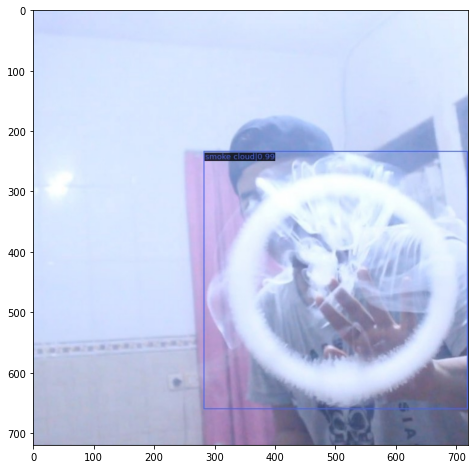

In [30]:
# test a single image and show the results
img = img_prefix / 'dolphinxx_==2019-04-03_18-19-28_UTC.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)

# Save the visualization results to image file
model.show_result(img, result, out_file = 'result.jpg')

# Visualize the results
import matplotlib.pyplot as plt
predicted_img = mmcv.imread('result.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

In [7]:
# Each element is one of the 8 classes.
# Each subelement is a bounding box for that class, along with classification probability.
# The specific class ordering is specified in the model config file (e.g. models/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco.py)
# Current class order: ('box', 'e-cigarette brand name', 'e-juice', 'e-juice flavor', 'mod', 'pod', 'smoke cloud', 'warning label nicotine')
result

[array([[2.8716095e+02, 2.3399422e+02, 7.1663837e+02, 6.5948138e+02,
         5.6847639e-02]], dtype=float32),
 array([[2.8716095e+02, 2.3399422e+02, 7.1663837e+02, 6.5948138e+02,
         1.3088877e-01]], dtype=float32),
 array([[2.8716095e+02, 2.3399422e+02, 7.1663837e+02, 6.5948138e+02,
         6.7970350e-02]], dtype=float32),
 array([[2.8716095e+02, 2.3399422e+02, 7.1663837e+02, 6.5948138e+02,
         6.6278622e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.8726263e+02, 2.3393825e+02, 7.1726514e+02, 6.6040497e+02,
         9.8883516e-01],
        [6.6836426e+02, 3.2085034e+02, 7.1859546e+02, 5.7322736e+02,
         6.0535714e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.8716095e+02, 2.3399422e+02, 7.1663837e+02, 6.5948138e+02,
         8.7326705e-02]], dtype=float32)]

### Predict on test set

In [8]:
import pyprojroot

dir_results = pyprojroot.here() / "data/annotations/"
test_json = dir_results / "v7-coco-test.json"
# See https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py for details.
from pycocotools.coco import COCO
coco = COCO(test_json)

test_files = {img['file_name']: 1 for img in coco.dataset['images']}

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [9]:
# Run on all images
extensions = {".png", ".jpg"}
# Restrict to images in the test set.
files = [p for p in img_prefix.glob("*") if p.suffix in extensions and p.name in test_files]
path_out = pyprojroot.here() / "data/detections/images-test-set"
print(f"Found {len(files)} files to analyze.")

Found 497 files to analyze.


In [10]:
%%time
# Takes 2.3 minutes

det_results = {}

from tqdm import tqdm
for file_i in tqdm(files):
    result = inference_detector(model, file_i)
    
    det_results[file_i.stem] = result

    # Save the visualization results to image files
    model.show_result(file_i, result, out_file = str(path_out / file_i.name))

100%|█████████████████████████████████████████| 497/497 [02:20<00:00,  3.55it/s]

CPU times: user 39min 7s, sys: 1min 18s, total: 40min 25s
Wall time: 2min 20s


In [11]:
# Save to disk.
import pickle

with open(pyprojroot.here() / 'data/test-set-detections.pickle', 'wb') as file:
    pickle.dump(det_results, file, protocol = pickle.HIGHEST_PROTOCOL)

In [12]:
# Upload to Google drive:
!rclone copy --progress {pyprojroot.here()}/data/detections/images-test-set/ gdrive:deep_learning/detections/images-test-set/

### Predict video

In [16]:
#
import os
video_dir = pyprojroot.here() / 'data-raw/vape/collection/appended_scrape_download/TikTok/General_users/Videos/'
video_list = ['Snaptik_6915093779842092289_marmikidzz.mp4.mp4',
              'Snaptik_6919047111870778626_trickytrish-on-ig.mp4 - Copy.mp4',
              'Snaptik_6922067949511609602_jellbryant.mp4.crdownload - Copy.mp4',
              'Snaptik_6914755138779467014_onlymids.mp4 - Copy (2) - Copy.mp4',
              'Snaptik_6916854323834031361_trickytrish-on-ig.mp4.crdownload - Copy - Copy.mp4']

def predict_video(video_name, box_threshold = 0.4, verbose = False):
    print("Analyzing", video_name)

    video_file = video_dir / video_name
    
    if not os.path.exists(video_file):
        print("Could not find video file")
        raise Exception
        
    path_out = pyprojroot.here() / "data/detections/videos" / Path(video_file).name
    if verbose:
        print("Output path:", path_out)
    
    # Default threshold is 0.3
    !python {pyprojroot.here()}/external/mmdetection/demo/video_demo.py "{video_file}" \
        {path_model} \
        {file_checkpoint} \
        --out "{path_out}" \
        --score-thr {box_threshold}

In [18]:
for video_name in video_list:
    # Second argument is the probability threshold for showing a bounding box.
    predict_video(video_name, 0.4)

Analyzing Snaptik_6915093779842092289_marmikidzz.mp4.mp4
load checkpoint from local path: work_dirs/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco/latest.pth
2022-05-23 10:26:01,987 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-05-23 10:26:01,988 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-05-23 10:26:01,989 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-05-23 10:26:01,990 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-05-23 10:26:01,991 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-05-23 10:26:01,992 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-05-23 10:26:01,994 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-05-23 10:26:01,995 - root - INFO - M

In [19]:
# Upload to Google drive:
!rclone copy --progress {path_out.parent} gdrive:deep_learning/detections/videos

Transferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Errors:                 0
Checks:                 0 / 0, -
Transferred:            0 / 0, -
Elapsed time:          0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Errors:                 0
Checks:               114 / 114, 100%
Transferred:            0 / 0, -
Elapsed time:          0sTransferred:   	    6.895M / 90.961 MBytes, 8%, 23.393 MBytes/s, ETA 3s
Errors:                 0
Checks:               119 / 119, 100%
Transferred:            0 / 5, 0%
Elapsed time:       200ms
Transferring:
 * videos/Snaptik_6914755… - Copy (2) - Copy.mp4:100% /6.095M, 0/s, -
 * videos/Snaptik_6915093…289_marmikidzz.mp4.mp4:  1% /13.794M, 0/s, -
 * videos/Snaptik_6916854…load - Copy - Copy.mp4:  0% /21.776M, 0/s, -
 * videos/Snaptik_6919047…h-on-ig.mp4 - Copy.mp4:  2% /22.093M, 0/s, -Transferred:   	   49.791M / 90.961 MBytes, 55%, 62.625 MBytes/s, ETA 0s
Errors:                 0
Checks:               119 / 119, 100%
Transferred:    